In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import copy
import scipy.sparse

## Directive solution with Black-Scholes formula

Solving with the formula:

\begin{equation}
C = S_0 N(d1) - X e^{-rT} N(d2)
\end{equation}

In [51]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def direct_solution(K, r, sigma, T, S_max, S_min, N, M):

    # Mesh
    T_grid = np.linspace(start=T/N, stop=T, num=N)
    S_grid = np.linspace(start=S_min, stop=S_max, num=M)
    S_mesh, T_mesh = np.meshgrid(S_grid, T_grid)
    
    call_prices_base = black_scholes_call_price(S_mesh, K, T_mesh, r, sigma)
    
    return S_mesh, T_mesh, call_prices_base

In [58]:
def plot_solution(S_mesh, T_mesh, direct_prices, name='tmp'):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S_mesh, T_mesh, direct_prices, cmap='viridis')
    ax.set_xlabel('Stock Price')
    ax.set_ylabel('Time to Expiration (years)')
    ax.set_zlabel('Call Option Price')

    # Change the rotation
    elevation_angle = 30  # in degrees
    azimuth_angle = -135  # in degrees
    ax.view_init(elevation_angle, azimuth_angle)
    plt.savefig(f'/Users/mark/Desktop/{name}.png')

    plt.show()

## Numeric solution

Solving with the recurrent formula:
\begin{equation}
C_i^{n-1} = C_i^n + \Delta t \left( \frac{1}{2}\sigma^2 S_i^2 \frac{C_{i+1}^n - 2C_i^n + C_{i-1}^n}{\Delta S^2} + rS_i\frac{C_{i+1}^n - C_{i-1}^n}{2\Delta S} - rC_i^n \right)
\end{equation}

In [59]:
def numeric_solution(K, r, sigma, T, S_max, S_min, N, M):
    
    S_grid = np.linspace(S_min, S_max, M)
    T_grid = np.linspace(0, T, N)
    dS = S_grid[1] - S_grid[0]
    dT = T_grid[1] - T_grid[0]

    call_prices_numeric = np.zeros((N, M))

    # Boundary conditions
    call_prices_numeric[0] = np.maximum(S_grid - K, 0)
    call_prices_numeric[:, 0] = 0
    call_prices_numeric[:, -1] = S_max - np.exp(-r * (1 - np.arange(N) / 365)) * K

    cnt = 0
    for time_index in range(1, N):
        for i in range(1, M - 1):
            a = call_prices_numeric[time_index - 1][i - 1]
            b = call_prices_numeric[time_index - 1][i]
            c = call_prices_numeric[time_index - 1][i + 1]

            call_prices_numeric[time_index][i] = b + dT * (0.5 * sigma ** 2 * S_grid[i] ** 2 * (a - 2 * b + c) / (dS ** 2) + r * S_grid[i] * (c - a) / (2 * dS) - r * b)
            cnt += 1

    S_mesh, T_mesh = np.meshgrid(S_grid, T_grid)
    
    return S_mesh, T_mesh, call_prices_numeric

## Experiments

In [60]:
# Parameters

K = 50  # Strike price
r = 0.02  # Risk-free interest rate
sigma = 0.2  # Volatility
T = 0.25 # Time in years to experience

S_max = 60 # max price
S_min = 40 # min price

N = 50  # Number of time steps
M = 20  # Number of price steps

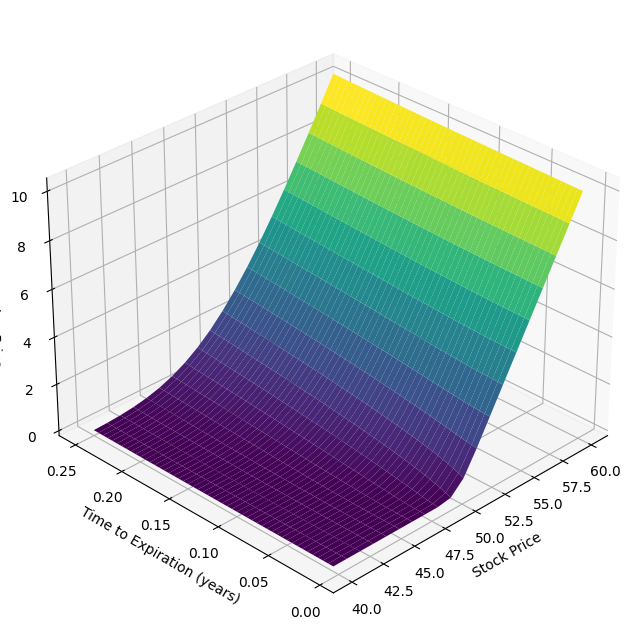

In [61]:
S_mesh, T_mesh, direct_prices = direct_solution(K, r, sigma, T, S_max, S_min, N, M)

plot_solution(S_mesh, T_mesh, direct_prices, 'direct')

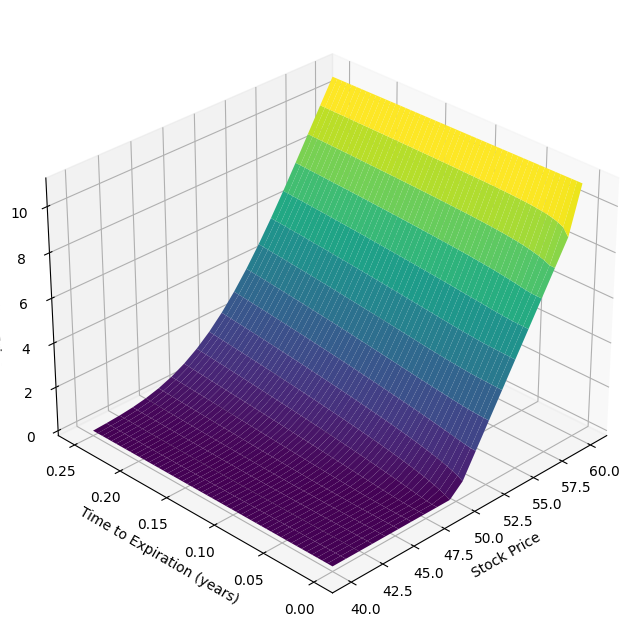

In [62]:
S_mesh, T_mesh, numeric_prices = numeric_solution(K, r, sigma, T, S_max, S_min, N, M)

plot_solution(S_mesh, T_mesh, numeric_prices, 'numeric')

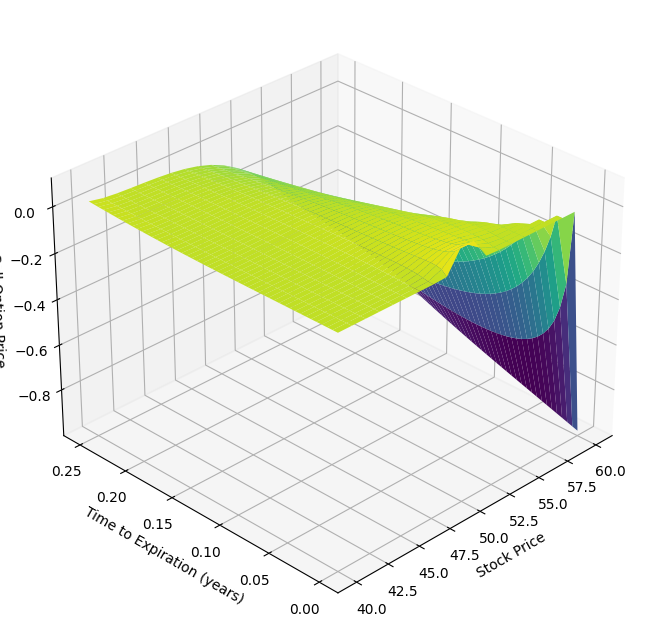

In [63]:
plot_solution(S_mesh, T_mesh, direct_prices - numeric_prices, 'diff')